<a href="https://colab.research.google.com/github/Geetika-L/Econ_472/blob/dev/Econ_472_RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
!pip install scikit-optimize --user
!pip install scikit-learn==1.2.1 --user
!pip install numpy==1.22.4 --user
!pip install shap --user

In [3]:
data_v1 = pd.read_csv('fred_data_trans_v1.csv')


In [4]:
current = pd.read_csv('current.csv')

In [5]:
## Replace CPI transformation by CPI_yoy growth
CPI = current['CPIAUCSL'][1:]
CPI_yoy = CPI.pct_change(periods=12)*100
data_v1['pi'] = CPI_yoy[12:].reset_index(drop=True)

In [6]:
percent_missing = list(data_v1.isna().sum()/(data_v1.shape[0]))
missing_value_df = pd.DataFrame({'column_name': data_v1.columns,
                                 'percent_missing': percent_missing})

In [7]:
## Prportion of columns that have high NAs
missing_value_df_01 = missing_value_df.loc[missing_value_df['percent_missing']>0.1]
## Higher than 0.1 (ACOGNO:New Orders for Consumer Goods, ANDENOx: New Orders for Nondefense Capital Goods,  TWEXAFEGSMTHx: Trade weighted us dollar index)

In [8]:
## Remove high proportion of NAs
col_to_rem_NA = missing_value_df_01['column_name'].tolist()
data_v1.drop(col_to_rem_NA, axis =1, inplace= True)


In [9]:
## Remove all CPI columns. CPI all items has been transformed in inflation
cpis_except_all_items = ['CPIAUCSL','CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAD', 'CUSR0000SAS', 'CPIULFSL', 'CUSR0000SA0L2', 'CUSR0000SA0L5']
data_v1.drop(cpis_except_all_items, axis =1, inplace= True)


In [10]:
date_col = data_v1['date']

In [11]:
## Remove the date column
data_v1.drop('date', axis =1, inplace= True)

In [12]:
## Creating lag and AR variables
def series_to_supervised(data, n_in=1, n_out=[1,3,6,12]):
 """
 Frame a time series as a supervised learning dataset.
 Arguments:
 data: Sequence of observations as a list or NumPy array.
 n_in: Number of lag observations as input (X).
 n_out: Number of observations as output (y).
 dropnan: Boolean whether or not to drop rows with NaN values.
 Returns:
 Pandas DataFrame of series framed for supervised learning.
 """

 n_vars = 1 if type(data.values) is list else data.shape[1]
 colnames = list(data.columns)
 cols, names = list(), list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
   cols.append(data.shift(i))
   names += [j+"_(t-{0})".format(i) for j in colnames]
 for i in n_out:   
     pi_shift = data['pi'].shift(-i+1)
     cols.append(pi_shift)
     names += ['pi_(t+{0})'.format(i-1)]

 # put it all together
 agg = pd.concat(cols, axis=1)
 agg.columns = names
 return agg

In [13]:
data_lagged = series_to_supervised(data_v1,n_in=3, n_out = [1,3,6,12])

In [14]:
data_lagged_sorted = data_lagged.reindex(sorted(data_lagged.columns), axis=1)

In [15]:
data_lagged_sorted.to_csv('data_lagged_all_horizons.csv')

In [16]:
data_lagged.shape

(756, 349)

In [17]:
## Remove missing lags ( 3 at the beginning, 5 at the end)
## Stop training set at December 2020 (with lags last row is Nov 2020 - Oct 2020)
## The rest - NAns are test set

##Create a date index
start_date = pd.to_datetime('12-1959', format='%m-%Y')
end_date = pd.to_datetime('11-2022', format='%m-%Y')
date_list = list(map(lambda x: x.strftime('%Y-%m-%d'), pd.date_range(start_date, end_date, freq="MS")))
data_lagged.set_index(pd.Series(date_list), inplace=True)

In [18]:
## Create train and test sets - T1
#columns_x = data_lagged.columns.drop(['pi_(t+0)','pi_(t+2)', 'pi_(t+5)', 'pi_(t+11)'])

data_lagged_train_x = data_lagged.loc['1960-03-01':'2020-11-01', :].drop(['pi_(t+0)','pi_(t+2)', 'pi_(t+5)', 'pi_(t+11)'], axis=1)

data_lagged_test_t1 = data_lagged.loc['2020-12-01':, ]#.drop(['pi_(t+2)', 'pi_(t+5)', 'pi_(t+11)'], axis =1)
data_lagged_test_t1 = data_lagged_test_t1[data_lagged_test_t1['pi_(t+0)'].notna()]
data_lagged_test_x_t1 = data_lagged_test_t1.drop(['pi_(t+0)','pi_(t+2)', 'pi_(t+5)', 'pi_(t+11)'], axis =1)
data_lagged_test_y_t1 =  data_lagged_test_t1['pi_(t+0)']

In [19]:
## Create train and test sets - T3

data_lagged_test_t3 = data_lagged.loc['2020-12-01':, ]#.drop(['pi_(t+2)', 'pi_(t+5)', 'pi_(t+11)'], axis =1)
data_lagged_test_t3 = data_lagged_test_t3[data_lagged_test_t3['pi_(t+2)'].notna()]
data_lagged_test_x_t3 = data_lagged_test_t3.drop(['pi_(t+0)','pi_(t+2)', 'pi_(t+5)', 'pi_(t+11)'], axis =1)
data_lagged_test_y_t3 =  data_lagged_test_t3['pi_(t+2)']

In [20]:
## Create train and test sets - T6

data_lagged_test_t6 = data_lagged.loc['2020-12-01':, ]#.drop(['pi_(t+2)', 'pi_(t+5)', 'pi_(t+11)'], axis =1)
data_lagged_test_t6 = data_lagged_test_t6[data_lagged_test_t6['pi_(t+5)'].notna()]
data_lagged_test_x_t6 = data_lagged_test_t6.drop(['pi_(t+0)','pi_(t+2)', 'pi_(t+5)', 'pi_(t+11)'], axis =1)
data_lagged_test_y_t6 =  data_lagged_test_t6['pi_(t+5)']

In [21]:
## Create train and test sets - T12

data_lagged_test_t12 = data_lagged.loc['2020-12-01':, ]#.drop(['pi_(t+2)', 'pi_(t+5)', 'pi_(t+11)'], axis =1)
data_lagged_test_t12 = data_lagged_test_t12[data_lagged_test_t12['pi_(t+11)'].notna()]
data_lagged_test_x_t12= data_lagged_test_t12.drop(['pi_(t+0)','pi_(t+2)', 'pi_(t+5)', 'pi_(t+11)'], axis =1)
data_lagged_test_y_t12 =  data_lagged_test_t12['pi_(t+11)']

In [22]:
## Getting mean of training dataset to impute
import numpy as np
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values = np.nan, strategy = 'mean').set_output(transform="pandas")
imp.fit(data_lagged_train_x)

SimpleImputer()

In [23]:
##Impute training data x

## impute testing data y_t1, y_t3, y_t6_, y_t2
data_lagged_test_x_imp_t1 = imp.transform(data_lagged_test_x_t1)
data_lagged_test_x_imp_t3 = imp.transform(data_lagged_test_x_t3)
data_lagged_test_x_imp_t6 = imp.transform(data_lagged_test_x_t6)
data_lagged_test_x_imp_t12 = imp.transform(data_lagged_test_x_t12)

In [24]:
## Import models
from joblib import load

model_t1 = load('search_v3.joblib')
model_t3 = load('search_t3_2.joblib')
model_t6 = load('search_t6_2.joblib')
model_t12 = load('search_t12_2.joblib')

In [25]:
## For t1, we need to change the colmun names
col_names_mod_t1 = []

for i in list(data_lagged_test_x_imp_t1.columns):
    if i[:2] == 'pi':
        col_names_mod_t1.append('CPIAUCSL_{0}'.format(i[-2]))
    else:
        col_names_mod_t1.append(i[:-5]+i[-2])
        
data_lagged_test_x_imp_t1.columns = col_names_mod_t1   
data_lagged_test_x_imp_t1 = data_lagged_test_x_imp_t1[list(model_t1.feature_names_in_)]

y_pred_t1 = model_t1.predict(data_lagged_test_x_imp_t1)

In [26]:
## Predict t3, t,6,12
y_pred_t3 = model_t3.predict(data_lagged_test_x_imp_t3)
y_pred_t6 = model_t6.predict(data_lagged_test_x_imp_t6)
y_pred_t12 = model_t12.predict(data_lagged_test_x_imp_t12)

In [27]:
## Prediction and actual for t1 model
df_t1_results= pd.DataFrame(data= {'actual': list(data_lagged_test_y_t1), 'predicted_t1': y_pred_t1}, index = list(map(lambda x: x.strftime('%Y-%m'), pd.date_range(pd.to_datetime('01-2021', format='%m-%Y'), pd.to_datetime('12-2022', format='%m-%Y'), freq="MS"))))

In [28]:
df_t3_results = pd.DataFrame(data= {'actual': list(data_lagged_test_y_t3), 'predicted_t3': y_pred_t3}, index = list(map(lambda x: x.strftime('%Y-%m'), pd.date_range(pd.to_datetime('03-2021', format='%m-%Y'), pd.to_datetime('12-2022', format='%m-%Y'), freq="MS"))))

In [29]:
df_t6_results = pd.DataFrame(data= {'actual': list(data_lagged_test_y_t6), 'predicted_t6': y_pred_t6}, index = list(map(lambda x: x.strftime('%Y-%m'), pd.date_range(pd.to_datetime('06-2021', format='%m-%Y'), pd.to_datetime('12-2022', format='%m-%Y'), freq="MS"))))

In [30]:
df_t12_results = pd.DataFrame(data= {'actual': list(data_lagged_test_y_t12), 'predicted_t12': y_pred_t12}, index = list(map(lambda x: x.strftime('%Y-%m'), pd.date_range(pd.to_datetime('12-2021', format='%m-%Y'), pd.to_datetime('12-2022', format='%m-%Y'), freq="MS"))))

In [31]:
df_all_horizons_results = pd.concat([df_t1_results, df_t3_results, df_t6_results, df_t12_results], axis=1)
df_all_horizons_results = df_all_horizons_results.loc['2022-01':,~df_all_horizons_results.columns.duplicated()]

In [32]:
df_all_horizons_results

,actual,predicted_t1,predicted_t3,predicted_t6,predicted_t12
2022-01,7.525934,6.794242,5.788581,4.410952,3.003298
2022-02,7.912024,7.050504,6.466510,4.627279,2.876057
2022-03,8.557586,7.559042,6.795402,4.784852,3.099481
2022-04,8.224139,8.054252,7.207659,5.500396,2.746874
2022-05,8.516413,8.005063,7.671198,6.259689,3.427169
2022-06,8.995221,8.116646,7.879742,6.812004,3.833982
2022-07,8.482130,8.796287,7.929654,7.870907,3.821091
2022-08,8.249235,8.372074,7.977046,8.656849,4.128892
2022-09,8.222410,8.158604,8.225961,9.273315,4.418329
2022-10,7.763115,8.071081,8.073747,9.024726,6.327184


In [33]:
df_all_horizons_results.index

Index(['2022-01', '2022-02', '2022-03', '2022-04', '2022-05', '2022-06',
       '2022-07', '2022-08', '2022-09', '2022-10', '2022-11', '2022-12'],
      dtype='object')

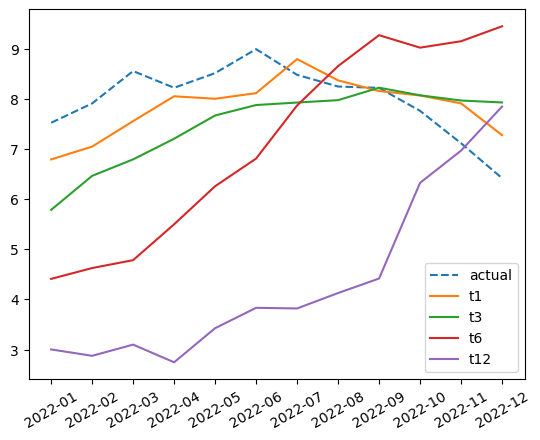

In [34]:
## Do 4 plots for test set Jan - Dec 2022
import matplotlib.pyplot as plt
date = df_all_horizons_results.index
plt.plot(date, df_all_horizons_results['actual'], label = 'actual', linestyle = 'dashed')
plt.plot(date, df_all_horizons_results['predicted_t1'], label = 't1')
plt.plot(date, df_all_horizons_results['predicted_t3'], label = 't3')
plt.plot(date, df_all_horizons_results['predicted_t6'], label = 't6')
plt.plot(date, df_all_horizons_results['predicted_t12'], label = 't12')
plt.xticks(rotation=30)
plt.legend()
plt.show()

In [35]:
## Find RMSE of all 4 models
from sklearn.metrics import mean_squared_error
df_all_horizons_rmse = pd.DataFrame({'horizon_1': [mean_squared_error(df_all_horizons_results['actual'], df_all_horizons_results['predicted_t1'])**0.5],
                        'horizon_3': [mean_squared_error(df_all_horizons_results['actual'], df_all_horizons_results['predicted_t3'])**0.5],
                        'horizon_6': [mean_squared_error(df_all_horizons_results['actual'], df_all_horizons_results['predicted_t6'])**0.5],
                        'horizon_12': [mean_squared_error(df_all_horizons_results['actual'], df_all_horizons_results['predicted_t12'])**0.5]})

In [36]:
df_all_horizons_rmse

,horizon_1,horizon_3,horizon_6,horizon_12
0,0.640239,1.106356,2.390314,4.237179


In [37]:
## ARIMA model from R
arima_results = pd.read_csv('arima_results.csv')
arima_predicted = arima_results['Point.Forecast']
arima_predicted

0     7.150126
1     6.952662
2     6.508534
3     5.979704
4     5.466960
5     4.915561
6     4.712970
7     4.636523
8     4.467440
9     3.841304
10    3.313904
11    2.929899
Name: Point.Forecast, dtype: float64

In [38]:
## Table comparing forecasts from Jan - Dec 2022
## Assume that at the end of year 2021, economists want to predict inflation for next year for 4 forecast hoirxons Jan, March, June , Dec 2022

df_arima_RF = pd.DataFrame({'2022-01': [df_all_horizons_results.loc['2022-01', 'actual'],df_all_horizons_results.loc['2022-01', 'predicted_t1'],arima_predicted[0]],
                           '2022-03': [df_all_horizons_results.loc['2022-03', 'actual'],df_all_horizons_results.loc['2022-03', 'predicted_t3'],arima_predicted[2]],
                            '2022-06': [df_all_horizons_results.loc['2022-06', 'actual'],df_all_horizons_results.loc['2022-06', 'predicted_t6'],arima_predicted[5]],
                            '2022-12': [df_all_horizons_results.loc['2022-12', 'actual'],df_all_horizons_results.loc['2022-12', 'predicted_t12'],arima_predicted[11]]
                           }, index = ['actual value', 'RF prediction', 'ARIMA prediction'])


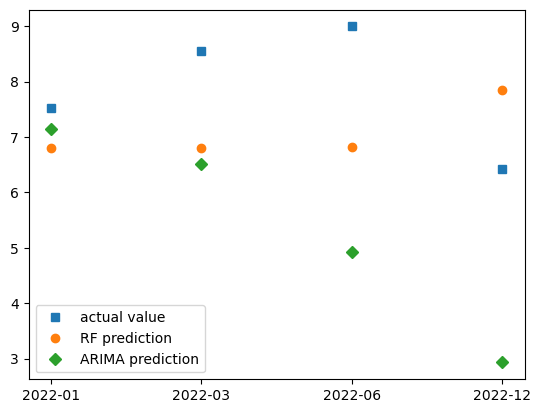

In [39]:
plt.plot(df_arima_RF.columns, df_arima_RF.loc['actual value',:], label = 'actual value',  linestyle = 'None', marker = 's')
plt.plot(df_arima_RF.columns, df_arima_RF.loc['RF prediction',:], label = 'RF prediction',  linestyle = 'None', marker = 'o')
plt.plot(df_arima_RF.columns, df_arima_RF.loc['ARIMA prediction',:], label = 'ARIMA prediction',linestyle = 'None', marker = 'D')
plt.legend()
plt.show()

In [40]:
## Mean squared error ratios

df_arima_RF_t = df_arima_RF.T
df_arima_RF_t['RMSE_RF'] = abs(df_arima_RF_t['actual value'] - df_arima_RF_t['RF prediction'])
df_arima_RF_t['RMSE_ARIMA'] = abs(df_arima_RF_t['actual value'] - df_arima_RF_t['ARIMA prediction'])
df_arima_RF_t['RMSE_ratio'] = np.round(df_arima_RF_t['RMSE_RF']/df_arima_RF_t['RMSE_ARIMA'],2)


In [41]:
df_arima_RF_t[['RMSE_ratio']]    

,RMSE_ratio
2022-01,1.95
2022-03,0.86
2022-06,0.54
2022-12,0.41


## Shapley values

In [42]:
## Recreating training set
data_lagged_train_x = data_lagged.loc['1960-03-01':'2020-11-01', :].drop(['pi_(t+0)','pi_(t+2)', 'pi_(t+5)', 'pi_(t+11)'], axis=1)
data_lagged_train_x_imp = imp.transform(data_lagged_train_x)

In [43]:
## Creating training set for t1 (since different naming style)

data_lagged_train_x_imp_t1 = data_lagged_train_x_imp.copy()
col_names_mod_t1 = []

for i in list(data_lagged_train_x_imp_t1.columns):
    if i[:2] == 'pi':
        col_names_mod_t1.append('CPIAUCSL_{0}'.format(i[-2]))
    else:
        col_names_mod_t1.append(i[:-5]+i[-2])
        
data_lagged_train_x_imp_t1.columns = col_names_mod_t1   
data_lagged_train_x_imp_t1 = data_lagged_train_x_imp_t1[list(model_t1.feature_names_in_)]

In [76]:
## Calculating global shapley values for t1, t3, t6, t12
import shap
explainer_t1 = shap.TreeExplainer(model_t1)
shap_values_t1 = explainer_t1.shap_values(data_lagged_train_x_imp_t1)

explainer_t3 = shap.TreeExplainer(model_t3)
shap_values_t3 = explainer_t3.shap_values(data_lagged_train_x_imp)

explainer_t6 = shap.TreeExplainer(model_t6)
shap_values_t6 = explainer_t6.shap_values(data_lagged_train_x_imp)

explainer_t12 = shap.TreeExplainer(model_t12)
shap_values_t12 = explainer_t12.shap_values(data_lagged_train_x_imp)

In [96]:
## Rescaling shapley values on sale of 0 - 1 and grouping by major groups
mean_shap_t1 = np.mean(abs(shap_values_t1),axis=0)
mean_shap_t3 = np.mean(abs(shap_values_t3),axis=0)
mean_shap_t6 = np.mean(abs(shap_values_t6),axis=0)
mean_shap_t12 = np.mean(abs(shap_values_t12),axis=0)


#Renaming columns for t1
col_names_mod_t1 = []

for i in list(data_lagged_train_x_imp_t1.columns):
    if i[:5] == 'CPIAU': 
        col_names_mod_t1.append('pi_(t-{0})'.format(i[-1]))
    else:
        col_names_mod_t1.append(i[:-1]+'(t-{0})'.format(i[-1]))

df_shap_1 = pd.DataFrame({'feature_names': col_names_mod_t1, 'shap': mean_shap_t1/sum(mean_shap_t1)}).sort_values(by = ['shap'],ascending=False)
df_shap_3 = pd.DataFrame({'feature_names': data_lagged_train_x_imp.columns, 'shap': mean_shap_t3/sum(mean_shap_t3)}).sort_values(by = ['shap'],ascending=False)
df_shap_6 = pd.DataFrame({'feature_names': data_lagged_train_x_imp.columns, 'shap': mean_shap_t6/sum(mean_shap_t6)}).sort_values(by = ['shap'],ascending=False)
df_shap_12 = pd.DataFrame({'feature_names': data_lagged_train_x_imp.columns, 'shap': mean_shap_t12/sum(mean_shap_t12)}).sort_values(by = ['shap'],ascending=False)


In [109]:
## Add groups to features
groups_and_features = pd.read_csv('fred_md_mapping.csv',encoding='ISO 8859-1')

In [116]:
df_t12_results

,actual,predicted_t12
2021-12,7.096542,3.067376
2022-01,7.525934,3.003298
2022-02,7.912024,2.876057
2022-03,8.557586,3.099481
2022-04,8.224139,2.746874
2022-05,8.516413,3.427169
2022-06,8.995221,3.833982
2022-07,8.482130,3.821091
2022-08,8.249235,4.128892
2022-09,8.222410,4.418329
